# 16. Screen Coordinates

Attempt to train a model using a heatmap of the screen coordinates in the session.

In [70]:
import gc
import logging
from typing import Tuple

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support

from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, concatenate
from keras import callbacks


import matplotlib.pyplot as plt

In [2]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

## Load Source Data

In [3]:
# load the source training set
df_source = pd.read_csv('data/train.csv.gz', compression='gzip', index_col=1)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 19)


,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
index,,,,,,,,,,,,,,,,,,,
0,20090312431273200,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [4]:
# load the source training labels
df_source_labels = pd.read_csv('data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Functions

### Functions to prepare the data

In [5]:
def map_question_to_level_group(question_number):
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'].apply(map_question_to_level_group) 
        
    return df_labels

In [6]:
def prepare_main_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)

    return df_main

## Functions for Feature Engineering

In [7]:
def get_session_screen_coor(data: pd.DataFrame, session_id: int):
    # get the session data
    session_data = df_source[df_source['session_id'] == session_id]
    session_data = session_data[['screen_coor_x', 'screen_coor_y']]
    session_data = session_data.dropna()

    # get the screen coordinates
    screen_coor_x = session_data['screen_coor_x'].values
    screen_coor_y = session_data['screen_coor_y'].values
    
    return screen_coor_x, screen_coor_y

(50, 50)


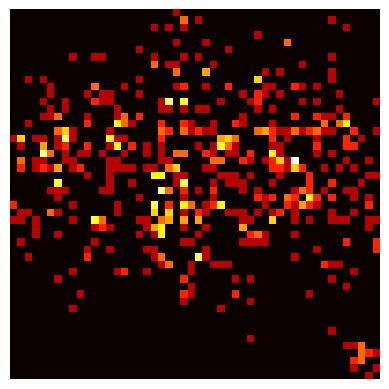

In [8]:
def create_heatmap(screen_coor_x, screen_coor_y):
    # Create the 2D histogram
    heatmap, xedges, yedges = np.histogram2d(screen_coor_y, screen_coor_x, bins=50)

    # Apply logarithmic transformation
    heatmap = np.log(heatmap + 1)

    # Normalize the heatmap
    normalized_heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Scale the heatmap to the range 0-255
    scaled_heatmap = (normalized_heatmap * 255).astype(np.uint8)

    return scaled_heatmap

# test the heatmap function
session_1_screen_coor_x, session_1_screen_coor_y =  \
    get_session_screen_coor(df_source, 20090312431273200)

session_1_heatmap = create_heatmap(session_1_screen_coor_x, session_1_screen_coor_y)
print(session_1_heatmap.shape)

plt.imshow(session_1_heatmap, cmap='hot', origin='lower')
plt.axis('off')
plt.show()

In [9]:
# # reshape for convolutional neural network 
# a = session_1_heatmap.reshape((session_1_heatmap.shape[0], session_1_heatmap.shape[1], 1))

# # try expand
# b = np.expand_dims(session_1_heatmap, axis=-1)

# np.array_equal(a, b)

### Functions to create datasets

In [10]:
def create_heatmap_vector_array(session_data: pd.DataFrame, 
                        level_group: int) -> np.array:
    """
    Creates a vector array for a specific session and question number.
    """
    # get the data for the session and level group
    df_session = session_data.query('level_group == @level_group')

    # get the data to create a heatmap
    heatmap_data = df_session[['screen_coor_x', 'screen_coor_y']].dropna()
    screen_coor_x = heatmap_data['screen_coor_x'].values
    screen_coor_y = heatmap_data['screen_coor_y'].values

    # create the heatmap
    heatmap = create_heatmap(screen_coor_x, screen_coor_y)

    # reshape the heatmap for the convolutional neural network
    vector_array = heatmap.reshape((heatmap.shape[0], heatmap.shape[1], 1))

    return vector_array

# test the vector array function
df_test = df_source[df_source['session_id'] == 21040510125933256]
test_vector_array_1 = create_heatmap_vector_array(df_source, '0-4')
test_vector_array_2 = create_heatmap_vector_array(df_source, '5-12')
test_vector_array_3 = create_heatmap_vector_array(df_source, '13-22')

print(test_vector_array_1.shape)
print(test_vector_array_2.shape)
print(test_vector_array_3.shape)

(50, 50, 1)
(50, 50, 1)
(50, 50, 1)


In [11]:
# df_source = prepare_main_dataset(df_source)
# df_source_labels = prepare_label_dataset(df_source_labels)

In [113]:
def create_dataset(X: pd.DataFrame,
                   y: pd.DataFrame,
                   session_list: list) -> Tuple[np.array, np.array, np.array]:
    """
    Creates a dataset for a specific set of sessions and question numbers.

    Parameters
    ----------
    X : pd.DataFrame
        The main dataset.

    y : pd.DataFrame
        The label dataset.

    session_ids : list
        The list of session ids.

    Returns
    -------
    Tuple[np.array, np.array]
        The features vector, image vector, and the labels.
    """
    X_image = []
    X_features = []
    y_dataset = []

    for session_id in tqdm(session_list):
        # get the session labels
        df_session_labels = y.query('session_id == @session_id')
        df_session = X.query('session_id == @session_id')

        # create the level group heatmaps
        vector_arrays = {
            '0-4': create_heatmap_vector_array(df_session, '0-4'),
            '5-12': create_heatmap_vector_array(df_session, '5-12'),
            '13-22': create_heatmap_vector_array(df_session, '13-22'),
        }
        # iterate over all the questions answered in the session
        for _, row in df_session_labels.iterrows():
            question_number = row['question_num']
            correct = row['correct']
            level_group = map_question_to_level_group(question_number)

            # create an array of zeros with 18 elements for each question
            X_features_row = np.zeros(18)

            # set the element to 1 equal to the question number
            X_features_row[question_number-1] = 1

            # append the output features
            X_features.append(X_features_row)

            # append the output image
            X_image.append(vector_arrays[level_group])

            # add the label to the dataset
            y_dataset.append(correct)

    X_out_features = np.array(X_features, dtype=np.float64)
    X_out_image = np.array(X_image, dtype=np.float64)
    y_out = np.array(y_dataset)

    return X_out_features, X_out_image, y_out

# # test the function
# session_list = [20090312431273200, 21040510125933256, 21040510125933256]
# X_test_features, X_test_image, y_test = create_dataset(df_source, df_source_labels, session_list)

# print(X_test_features.shape)
# print(X_test_image.shape)
# print(y_test.shape)

In [13]:
def select_sessions(
        y: pd.DataFrame,
        sample_size: int,
        random_state: int=1337) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Selects a sample of sessions from the dataset.

    Parameters
    ----------
    y : pd.DataFrame
        The label dataset.
    sample_size : int
        The number of sessions to select.
    random_state : int
        The random state to use.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        The selected session ids, the main dataset and the label dataset.
    """
    # select all the unique session ids
    all_session_ids = y['session_id'].unique()

    # create a sample for testing
    session_ids = np.random.choice(all_session_ids, size=sample_size, replace=False)

    # split the dataset into train, validation and test sets
    train, test = train_test_split(session_ids, test_size=0.3)
    test, val = train_test_split(test, test_size=0.5)

    # print the number of sessions in each set
    print(f'Train: {len(train)}')
    print(f'Validation: {len(val)}')
    print(f'Test: {len(test)}')

    return train, val, test

### Functions for Model Training

In [14]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [15]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [16]:
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    
    plot_loss(history)
    plot_accuracy(history)

    y_test_score = model.predict(X_test)
    threshold, _, _ = optimize_f1(y_test, y_test_score)

    print(classification_report(y_test, y_test_score > threshold))
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold

In [17]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

In [18]:
def train_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None) -> callbacks.History:
    """
    Train the keras model based on the parameters.

    Parameters
    ----------
    model : keras.models
        The model to train.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None
    
    Returns
    -------
    keras.callbacks.History
        The history of the training.
    """
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    # fit the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight)
    
    return history

In [19]:
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    
    plot_loss(history)
    plot_accuracy(history)

    y_test_score = model.predict(X_test)
    threshold, _, _ = optimize_f1(y_test, y_test_score)

    print(classification_report(y_test, y_test_score > threshold))
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold

In [20]:
def train_and_test_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None) -> float:
    """
    Train and test the model.

    Parameters
    ----------
    model : keras.models
        The model to train and test.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        class_weight=class_weight)
    
    gc.collect()

    return test_model(model, history, X_test, y_test)

## Pre-process Data

### Pre-defined Values

### Perform Pre-Processing

In [21]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source)

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13173445, 13)


,session_id,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1323,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,831,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [22]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
21476,22010116250792520,2,1,0-4
84068,21000111433937450,8,1,5-12
171219,21040510125933256,15,0,13-22


In [23]:
gc.collect()

35

## Parameters

In [147]:
random_state = 51
sample_size = df_source_labels['session_id'].nunique()
#sample_size = 4000

## Data Selection

In [148]:
train, val, test = select_sessions(
    y=df_source_labels,
    sample_size=sample_size,
    random_state=random_state)

Train: 8245
Validation: 1767
Test: 1767


## Create Datasets

In [149]:
# create the training dataset
X_train_features, X_train_image, y_train = create_dataset(
    X=df_source, y=df_source_labels, session_list=train)
gc.collect()

  0%|          | 0/8245 [00:00<?, ?it/s]

308

In [150]:
# create the validation dataset
X_val_features, X_val_image, y_val = create_dataset(
    X=df_source, y=df_source_labels, session_list=val)
gc.collect()

  0%|          | 0/1767 [00:00<?, ?it/s]

308

In [151]:
# create the test dataset
X_test_features, X_test_image, y_test = create_dataset(
    X=df_source, y=df_source_labels, session_list=test)
gc.collect()

  0%|          | 0/1767 [00:00<?, ?it/s]

248

## Model Training

reference: [Conv2d for image with additional features as input layer](https://datascience.stackexchange.com/questions/106801/conv2d-for-image-with-additional-features-as-input-layer)

### Basic

Epoch 1/10
2319/2319 [==============================] - 4s 2ms/step - loss: 0.5333 - accuracy: 0.7298 - val_loss: 0.5250 - val_accuracy: 0.7359
Epoch 2/10
2319/2319 [==============================] - 4s 2ms/step - loss: 0.5319 - accuracy: 0.7301 - val_loss: 0.5222 - val_accuracy: 0.7359
Epoch 3/10
2319/2319 [==============================] - 4s 2ms/step - loss: 0.5315 - accuracy: 0.7301 - val_loss: 0.5221 - val_accuracy: 0.7352
Epoch 4/10
2319/2319 [==============================] - 4s 2ms/step - loss: 0.5313 - accuracy: 0.7302 - val_loss: 0.5225 - val_accuracy: 0.7365
Epoch 5/10
2319/2319 [==============================] - 4s 2ms/step - loss: 0.5311 - accuracy: 0.7305 - val_loss: 0.5229 - val_accuracy: 0.7352
Epoch 6/10
2319/2319 [==============================] - 4s 2ms/step - loss: 0.5311 - accuracy: 0.7305 - val_loss: 0.5225 - val_accuracy: 0.7352
Epoch 7/10
2319/2319 [==============================] - 4s 2ms/step - loss: 0.5310 - accuracy: 0.7305 - val_loss: 0.5218 - val_accuracy:

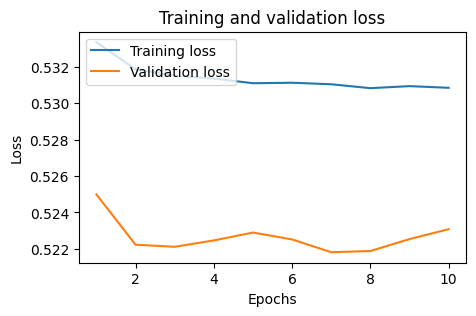

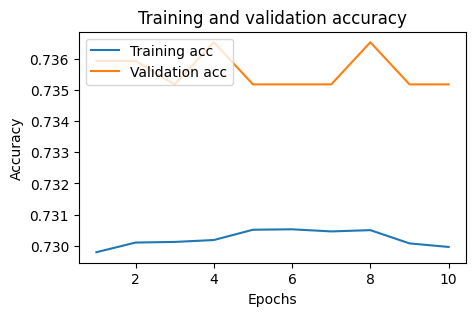

994/994 [==============================] - 1s 492us/step
              precision    recall  f1-score   support

           0       0.49      0.55      0.52      9432
           1       0.80      0.76      0.78     22374

    accuracy                           0.70     31806
   macro avg       0.64      0.65      0.65     31806
weighted avg       0.71      0.70      0.70     31806

Optimized threshold for best F1: 0.64


0.64

In [152]:
# # create the model
model = Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(18,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

train_and_test_model(
    model=model,
    X_train=X_train_features,
    y_train=y_train,
    X_val=X_val_features,
    y_val=y_val,
    X_test=X_test_features,
    y_test=y_test,
    epochs=10,
    batch_size=64,
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

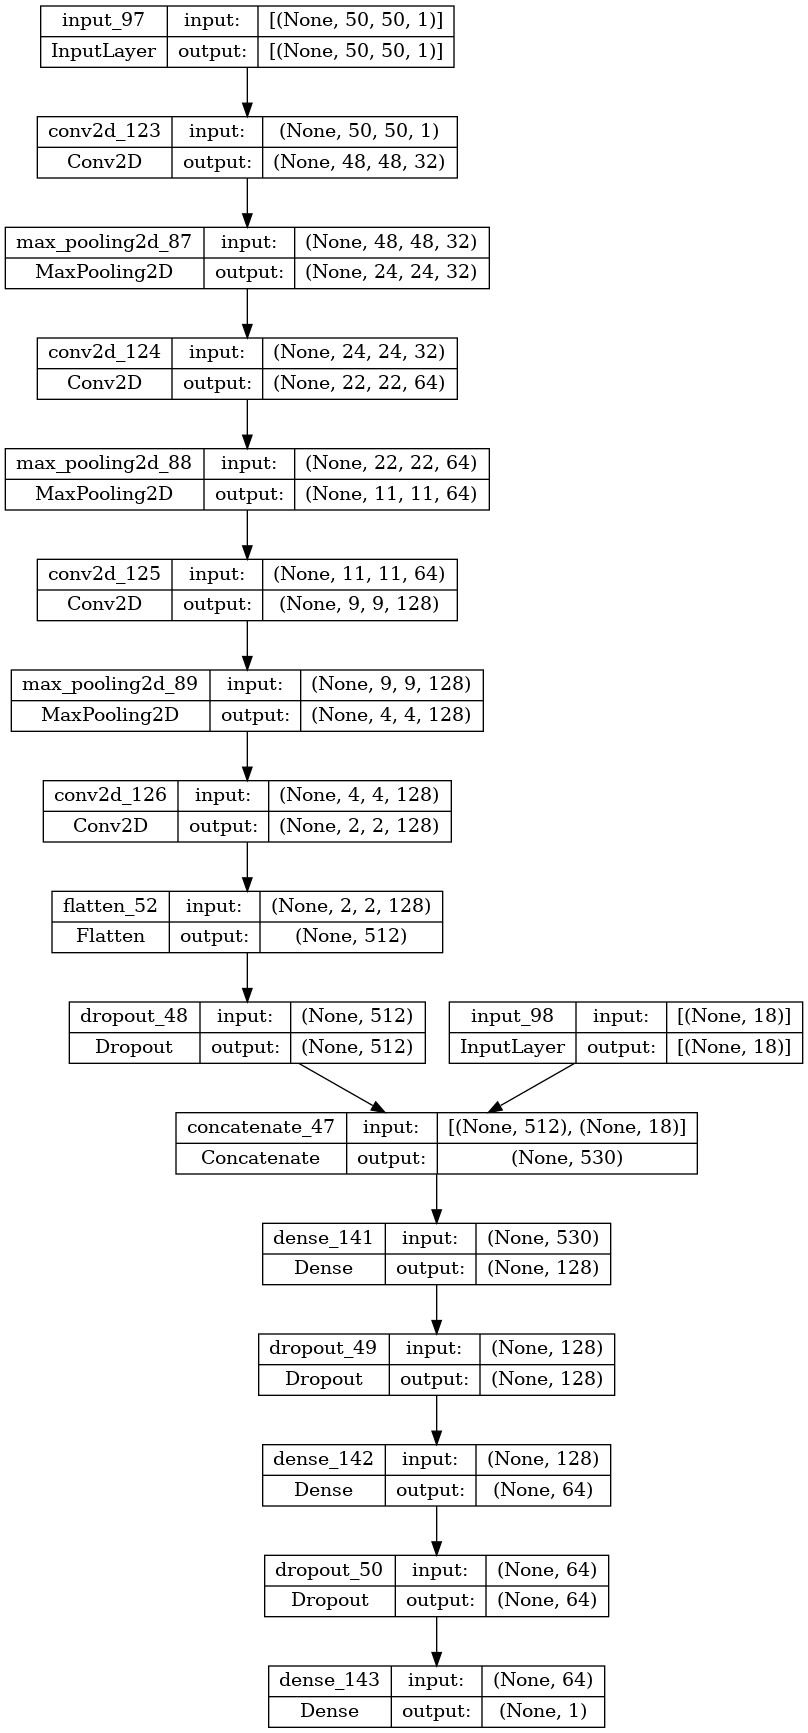

In [153]:
input_image = Input(shape=(50, 50, 1))
input_features = Input(shape=(18,))

# apply convolutional layers to image branch
x = Conv2D(32, (3, 3), activation='relu')(input_image)
x = MaxPool2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)

# concatenate flattened image branch with input features
concat = concatenate([x, input_features])

# apply dense layers on concatenated data

# dense = Dense(512)(concat)
# dense = Dense(512)(dense)
# output = Dense(1, activation='sigmoid')(dense)


dense = Dense(128)(concat)
dense = Dropout(0.5)(dense)
dense = Dense(64)(dense)
dense = Dropout(0.5)(dense)
output = Dense(1, activation='sigmoid')(dense)

# create models using inputs and output specified above
model = Model(inputs=[input_image, input_features], outputs=output)

# plot the model architecture
keras.utils.plot_model(model, show_shapes=True)

Epoch 1/30
1485/1485 [==============================] - 7s 4ms/step - loss: 1.0317 - accuracy: 0.6495 - val_loss: 0.5794 - val_accuracy: 0.7225
Epoch 2/30
1485/1485 [==============================] - 6s 4ms/step - loss: 0.5906 - accuracy: 0.7104 - val_loss: 0.5638 - val_accuracy: 0.7277
Epoch 3/30
1485/1485 [==============================] - 6s 4ms/step - loss: 0.5700 - accuracy: 0.7213 - val_loss: 0.5478 - val_accuracy: 0.7313
Epoch 4/30
1485/1485 [==============================] - 6s 4ms/step - loss: 0.5564 - accuracy: 0.7263 - val_loss: 0.5377 - val_accuracy: 0.7345
Epoch 5/30
1485/1485 [==============================] - 6s 4ms/step - loss: 0.5481 - accuracy: 0.7286 - val_loss: 0.5312 - val_accuracy: 0.7395
Epoch 6/30
1485/1485 [==============================] - 6s 4ms/step - loss: 0.5428 - accuracy: 0.7309 - val_loss: 0.5273 - val_accuracy: 0.7395
Epoch 7/30
1485/1485 [==============================] - 6s 4ms/step - loss: 0.5404 - accuracy: 0.7301 - val_loss: 0.5261 - val_accuracy:

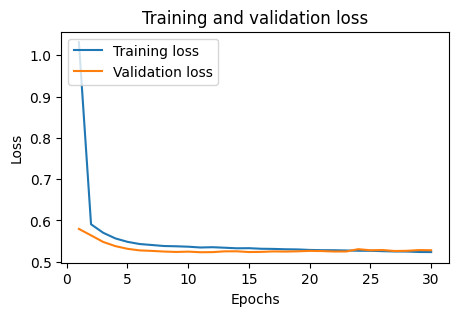

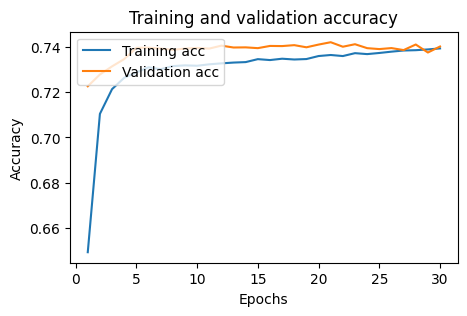

994/994 [==============================] - 1s 933us/step
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      9432
           1       0.79      0.80      0.79     22374

    accuracy                           0.71     31806
   macro avg       0.65      0.65      0.65     31806
weighted avg       0.71      0.71      0.71     31806

Optimized threshold for best F1: 0.63


0.63

In [154]:
train_and_test_model(
    model=model,
    X_train=[X_train_image, X_train_features],
    y_train=y_train,
    X_val=[X_val_image, X_val_features],
    y_val=y_val,
    X_test=[X_test_image, X_test_features],
    y_test=y_test,
    epochs=30,
    batch_size=100,
    optimizer=optimizers.RMSprop(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy'])